# Analysis of the attack: Adult No Clustering based on Targets
Analysis of the attack on Adult with the clustering made without considering the target variable. The black box model is the one created on the data generated with K = 6 for the clustering.
The data used for this attack are generated without the noisy validation dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pathlib import Path
import os
import sys
import bz2
import pickle
np.random.seed(10)
# adds the visibility of the mlem module, needed to load the attack models
sys.path.append("../../../") 
import mlem

In [2]:
import warnings

Loading the bb and data (Clustering without target division, K=6, No noise in the dataset)

In [3]:
BLACK_BOX_PATH = './adult_no_target_division/K6/adult_randfor_k6.bz2'
EXPERIMENTS_RESULTS_FOLDER = "/home/gerardozinno/Desktop/risultati_no_cluster_on_targets/gaussian/same"
BLACK_BOX_DATA_PATH = './adult_no_target_division/K6/adult_randfor_k6_data.npz'
TRAIN_SET_CSV = 'adult_no_target_division/K6/train_k6.csv'
TEST_SET_CSV  = 'adult_no_target_division/K6/test_k6.csv'
NOISY_VALIDATION_SET_CSV = 'adult_no_target_division/K6/validation_k6-noisy.csv'
CENTROIDS_NEIGHBORS = 'adult_no_target_division/K6/train_cluster_k6.csv'

In [4]:
def get_attack_mod(index:int, targets=[0,1], base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the attack model was built
        targets (int | List(int)) - targets for the attack model.
    Returns:
        List containing the attack models (or model) for that particular index
    """
    if type(targets) is int:
        targets = [targets]
    loaded_models = []
    for t in targets:
        path = f"{base_folder}/{index}/attack/{t}/model.pkl.bz2"
        with bz2.BZ2File(path) as f:
            data = pickle.load(f)
            loaded_models.append(data)
    return loaded_models
        
def get_local_model(index:int, base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the local model was built.
    Returns:
        Local model
    """
    path = f"{base_folder}/{index}/black_box"
    local_model_path = f"{path}/model.pkl.bz2"
    with bz2.BZ2File(local_model_path) as lm:
        local_model = pickle.load(lm)
    return local_model

def get_local_model_data(index: int, base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the local model was built.
    Returns:
        Structure with keys x and y
    """
    path = f"{base_folder}/{index}/black_box"
    data_path = f"{path}/data.npz"
    loaded = np.load(data_path, allow_pickle=True)
    return loaded

#def get_subset_target_cluster(df, target, cluster):
#    """
#    Returns the subset of a dataframe with the specified target and cluster.
#    """
#    tmp = df[df['Target'] == target]
#    return tmp[tmp['Cluster'] == cluster]

def get_subset_cluster(df, cluster):
    """
    Returns the subset of a dataframe with the specified Cluster.
    """
    return df[df['Cluster'] == cluster]

def split_probs_array(arr):
    """
    
    """
    n_classes = len(arr[0])
    separated = []
    max_index_row = np.argmax(arr, axis=1)
    for c in range(n_classes):
        separated.append(arr[max_index_row == c])
    return separated

loading the data and the black box

In [5]:
with bz2.BZ2File(BLACK_BOX_PATH) as f:
    black_box = pickle.load(f)

In [6]:
loaded = np.load(BLACK_BOX_DATA_PATH, allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [7]:
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

doing some integrity checks

In [8]:
feat_cols = [
    'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status',
    'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss',
    'Hours-per-week', 'Native-country'
]
adult_train = pd.read_csv(TRAIN_SET_CSV)
adult_test = pd.read_csv(TEST_SET_CSV)
adult_test_subset_cluster = pd.read_csv(CENTROIDS_NEIGHBORS)
assert (adult_train[feat_cols] == x_train).all().all() and \
       (adult_test[feat_cols] == x_test).all().all()   and \
       (adult_test_subset_cluster[feat_cols] == x_test_clustered).all().all()

In [9]:
adult_train_ones = adult_train[adult_train['Target'] == 1]
adult_train_zeroes = adult_train[adult_train['Target'] == 0]

In [10]:
adult_train_ones

,Unnamed: 0,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target,Cluster
1,7690,0.575597,0.218918,-0.405804,0.164328,-0.440434,0.455011,0.133907,0.493599,0.263855,0.113783,-0.147502,-0.218673,-0.078031,0.254411,1,0
6,1551,0.423288,0.218918,-0.422453,0.746667,2.306068,0.455011,0.448686,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,1,3
8,15076,0.880215,0.218918,0.888546,0.200180,-0.048076,0.455011,0.225590,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,1,0
10,6353,0.423288,0.218918,-0.351762,0.421658,1.128996,0.455011,0.133907,0.455728,0.263855,0.313955,0.271314,-0.218673,-0.078031,0.254411,1,3
22,26628,-0.033639,0.218918,-0.163331,0.421658,1.128996,0.455011,0.485342,0.455728,0.263855,0.313955,1.880305,-0.218673,0.756794,0.254411,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16858,29794,1.032523,0.285829,-0.041531,0.421658,1.128996,0.455011,0.485342,0.455728,0.263855,0.313955,-0.147502,-0.218673,0.756794,0.254411,1,3
16859,14064,-0.033639,0.218918,-0.195832,0.564576,1.521353,0.455011,0.485342,0.455728,0.263855,0.313955,-0.147502,-0.218673,1.591619,0.254411,1,3
16860,9349,-0.795183,0.218918,2.197415,0.421658,1.128996,0.455011,0.485342,0.493599,0.263855,0.113783,-0.147502,-0.218673,1.591619,0.254411,1,5
16861,26970,1.946377,0.285829,-0.815394,0.164328,-0.440434,0.455011,0.270647,0.455728,0.263855,0.313955,-0.147502,-0.218673,-2.165095,0.254411,1,0


In [11]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [12]:
feat_cols = [
    'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status',
    'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss',
    'Hours-per-week', 'Native-country'
]

BASE_RESULTS_PATH = Path("ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING")
BASE_RESULTS_PATH.mkdir(exist_ok=False)

In [13]:
adult_test_subset_cluster['Cluster'].values

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5])

ind=0 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/00_c0
ind=1 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/01_c0
ind=2 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/02_c0
ind=3 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/03_c0
ind=4 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/04_c0
ind=5 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/05_c0
ind=6 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/06_c0
ind=7 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/07_c1
ind=8 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/08_c1
ind=9 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/09_c1
ind=10 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/10_c1
ind=11 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/11_c1
ind=12 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/12_c1
ind=13 clus=1 ADULT_AN

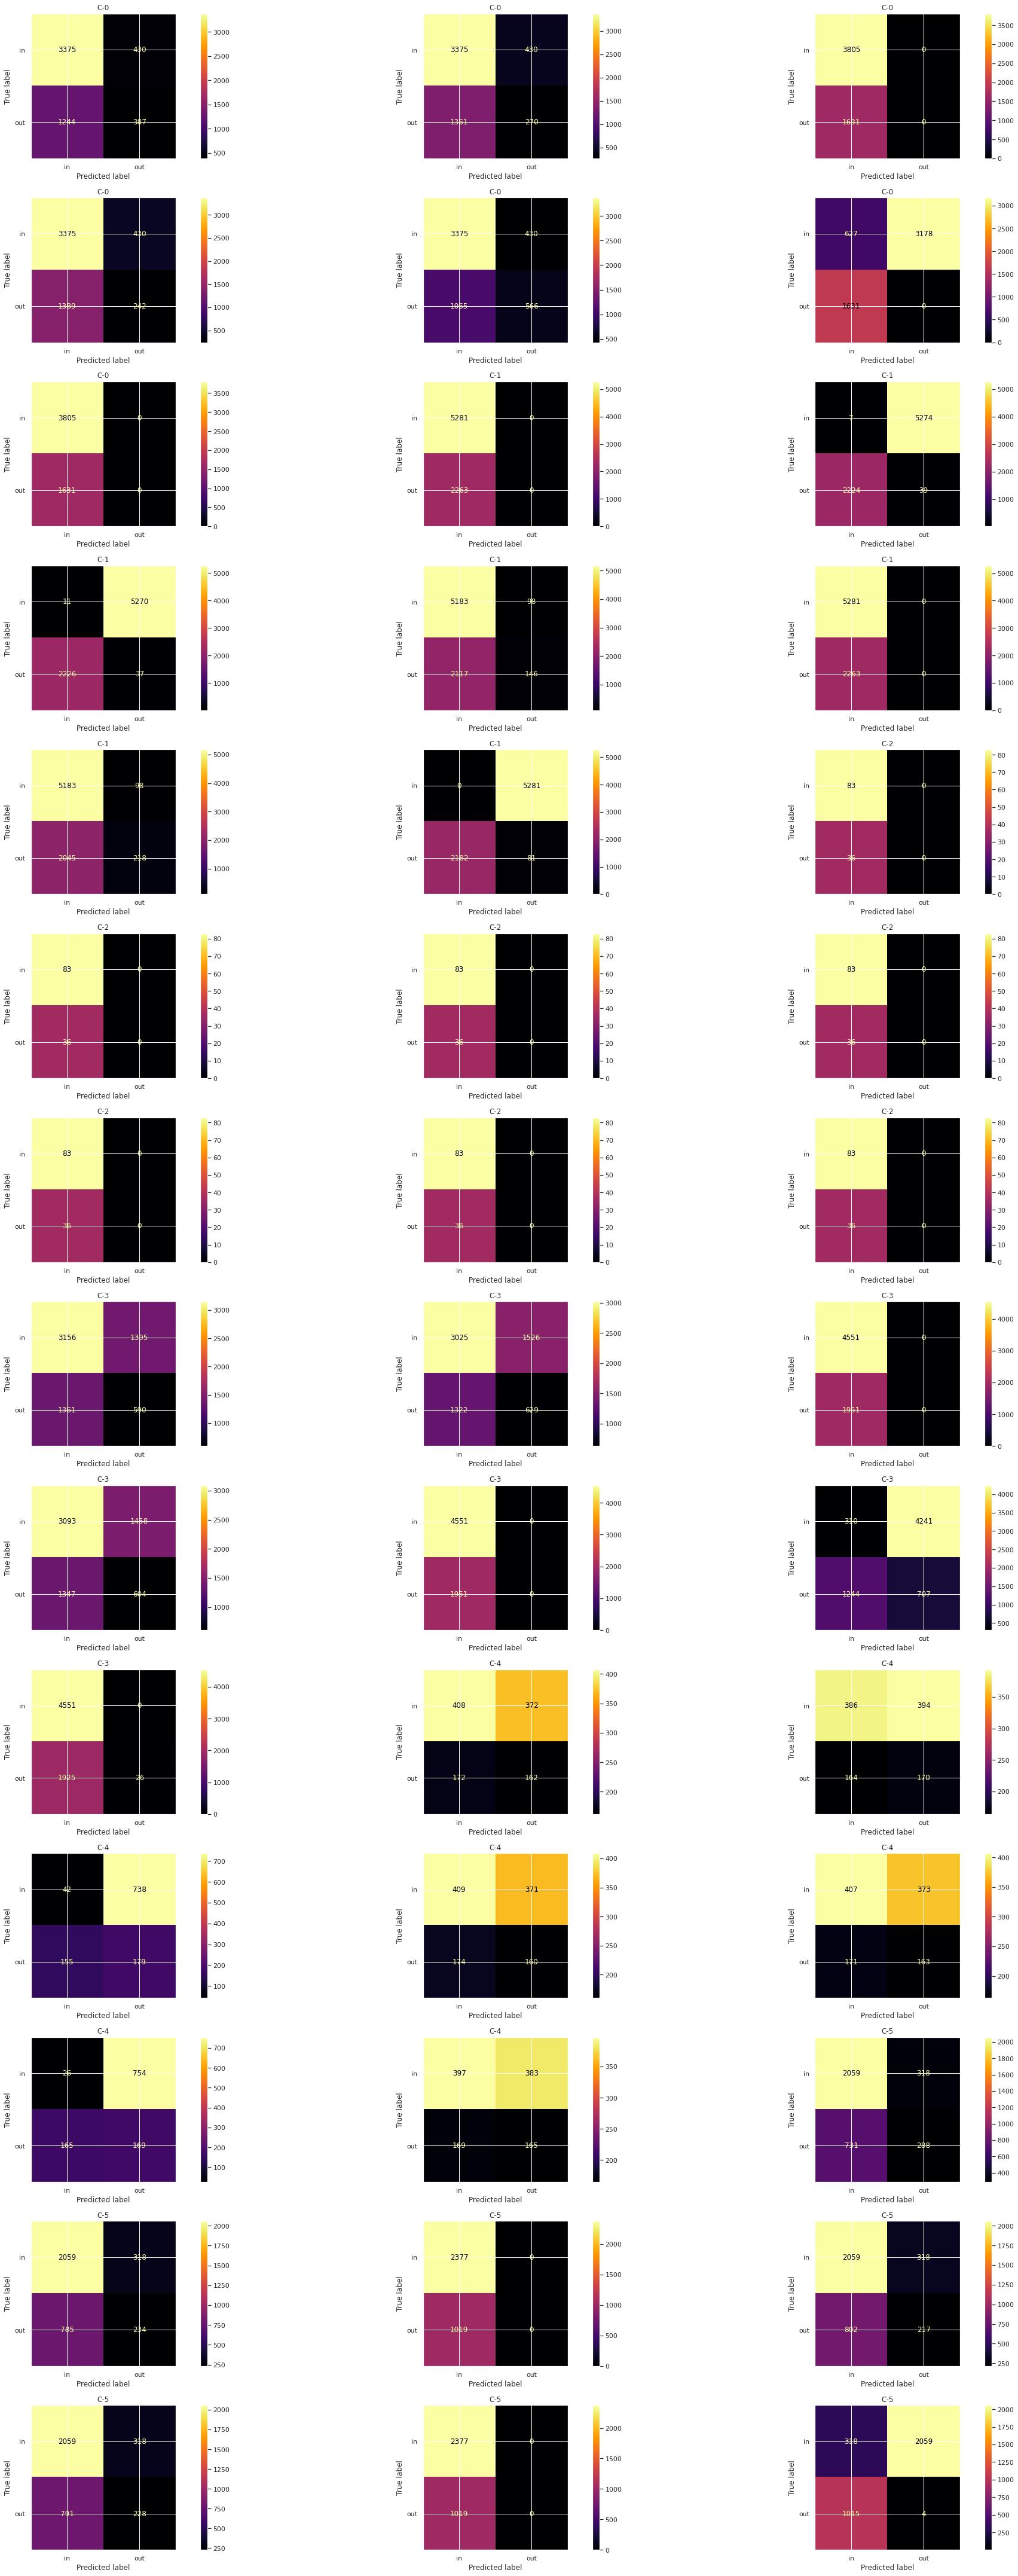

In [14]:
# NUOVA
fig, axs = plt.subplots(nrows=14, ncols=3, figsize=(30, 60))
axs_list = axs.ravel()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # for each (target, cluster)...
    for ind, clus in enumerate(adult_test_subset_cluster['Cluster'].values):
        ind_res_path = BASE_RESULTS_PATH / f"{ind:02d}_c{clus}"
        ind_res_path.mkdir(exist_ok=True)
        print(f"{ind=} {clus=} {ind_res_path}")
        # retrieve the attack models
        attack_0, attack_1 = get_attack_mod(ind)

        # TRAIN
        train_path = ind_res_path / "train"
        train_path.mkdir(exist_ok="true")
        # get the subset of the training set
        train_subset = get_subset_cluster(adult_train, clus)

        probs_train = black_box.predict_proba(train_subset[feat_cols].to_numpy())
        
        ones_train, zeroes_train = split_probs_array(probs_train)
        
        assert len(zeroes_train) + len(ones_train) == len(probs_train)

        if len(zeroes_train) > 0:
            atk_0_train = attack_0.predict(zeroes_train)
            report_0_train = classification_report(["in"]*len(atk_0_train), atk_0_train)
            with open(str(train_path / "0.txt"), "w") as f:
                f.write(report_0_train)

        if len(ones_train) > 0:
            atk_1_train = attack_1.predict(ones_train)
            report_1_train = classification_report(["in"]*len(atk_1_train), atk_1_train)
            with open(str(train_path / "1.txt"), "w") as f:
                f.write(report_1_train)
        
        l0tr = len(zeroes_train)
        l1tr = len(ones_train)
        
        train_results = None
        if l0tr == 0:
            train_results = atk_1_train
        elif l1tr == 0:
            train_results = atk_0_train
        else:
            train_results = np.concatenate((atk_0_train, atk_1_train))
        with open(str(train_path / "01.txt"), "w") as f:
            report_01_train = classification_report(["in"]*len(train_results), train_results)
            f.write(report_01_train)

        

        #TEST
        test_path = ind_res_path / "test"
        test_path.mkdir(exist_ok="true")
        # get test subset of the test set
        test_subset  = get_subset_cluster(adult_test, clus)

        probs_test = black_box.predict_proba(test_subset[feat_cols].to_numpy())
        ones_test, zeroes_test = split_probs_array(probs_test)
        assert len(zeroes_test) + len(ones_test) == len(probs_test)

        if len(zeroes_test) > 0:
            atk_0_test = attack_0.predict(zeroes_test)
            report_0_test = classification_report(["out"] * len(atk_0_test), atk_0_test)
            with open(str(test_path / "0.txt"), "w") as f:
                f.write(report_0_test)

        if len(ones_test) > 0:
            atk_1_test = attack_0.predict(ones_test)
            report_1_test = classification_report(["out"] * len(atk_1_test), atk_1_test)
            with open(str(test_path / "1.txt"), "w") as f:
                f.write(report_1_test)
        
        l0te = len(zeroes_test)
        l1te = len(ones_test)
        test_results = None
        if l0te == 0:
            test_results = atk_1_test
        elif l1te == 0:
            test_results = atk_0_test
        else:
            test_results = np.concatenate((atk_0_test, atk_1_test))
            
        with open(str(test_path / "01.txt"), "w") as f:
            report_01_train = classification_report(["out"]*len(test_results), test_results)
            f.write(report_01_train)
        
        # Concatenating test and train
        with open(str(ind_res_path / "traintest_full.txt"), "w") as f:
            full = np.concatenate((train_results, test_results))
            mask = ["in"] * len(train_results) + ["out"] * len(test_results)
            f.write(classification_report(mask, full))
            aa = axs_list[ind]
            ConfusionMatrixDisplay.from_predictions(mask, full, ax=aa, cmap='inferno')
            aa.set_title(f"C-{clus}")
            
plt.tight_layout()

# Using a Voting classifier

Classifier which implements the hard voting, it returns arrays containing "in" / "out" / "even" (this last case is possible only if there was an even number of classifiers)

In [15]:
from typing import List
class HardVotingClassifier:
    def __init__(self, classifiers: List):
        self.classifiers_ = classifiers
        self.nclass = len(classifiers)
        assert all([x.classes_ == self.classifiers_[0].classes_] for x in self.classifiers_)
    def predict(self, x):
        """
        Returns: array with classification, containing ["in", "out", "even"]
        """
        # use 1 for "in", -1 for "out", sum all the arrays and replace the values => 0 with in
        # the ones < 0 with out, return a boolean mask to indicate the ones where there was a 50/50
        # decision (only for when the number of classifiers is even)
        def convert_to_number(x):
            if x == "in":
                return 1
            elif x == "out":
                return -1
            else:
                raise ValueError(f"invalid argument {x}")
        def convert_to_inout(x):
            if x > 0:
                return "in"
            elif x < 0:
                return "out"
            else:
                return "even"
        
                
        convert_to_number_vectorized = np.vectorize(convert_to_number)
        convert_to_inout_vectorized  = np.vectorize(convert_to_inout)    
        
        predictions = [convert_to_number_vectorized(model.predict(x)) for model in self.classifiers_]
        
        return convert_to_inout_vectorized(sum(predictions))

In [16]:
BASE_VOTING_PATH = Path(BASE_RESULTS_PATH) / "HARD_VOTING"
BASE_VOTING_PATH.mkdir(exist_ok=False)
print(BASE_VOTING_PATH)

ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/HARD_VOTING


## Hard Voting

Here the hard voting is obtained by taking all the attack models for a given cluster.

cluster=0
len(atk0)=7 len(atk1)=7
0/5436 were even
cluster=1
len(atk0)=7 len(atk1)=7
0/7544 were even
cluster=2
len(atk0)=7 len(atk1)=7
ones_train=array([], shape=(0, 2), dtype=float64)
ones_test=array([], shape=(0, 2), dtype=float64)
0/119 were even
cluster=3


/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

len(atk0)=7 len(atk1)=7
0/6502 were even
cluster=4
len(atk0)=7 len(atk1)=7
0/1114 were even
cluster=5
len(atk0)=7 len(atk1)=7
0/3396 were even


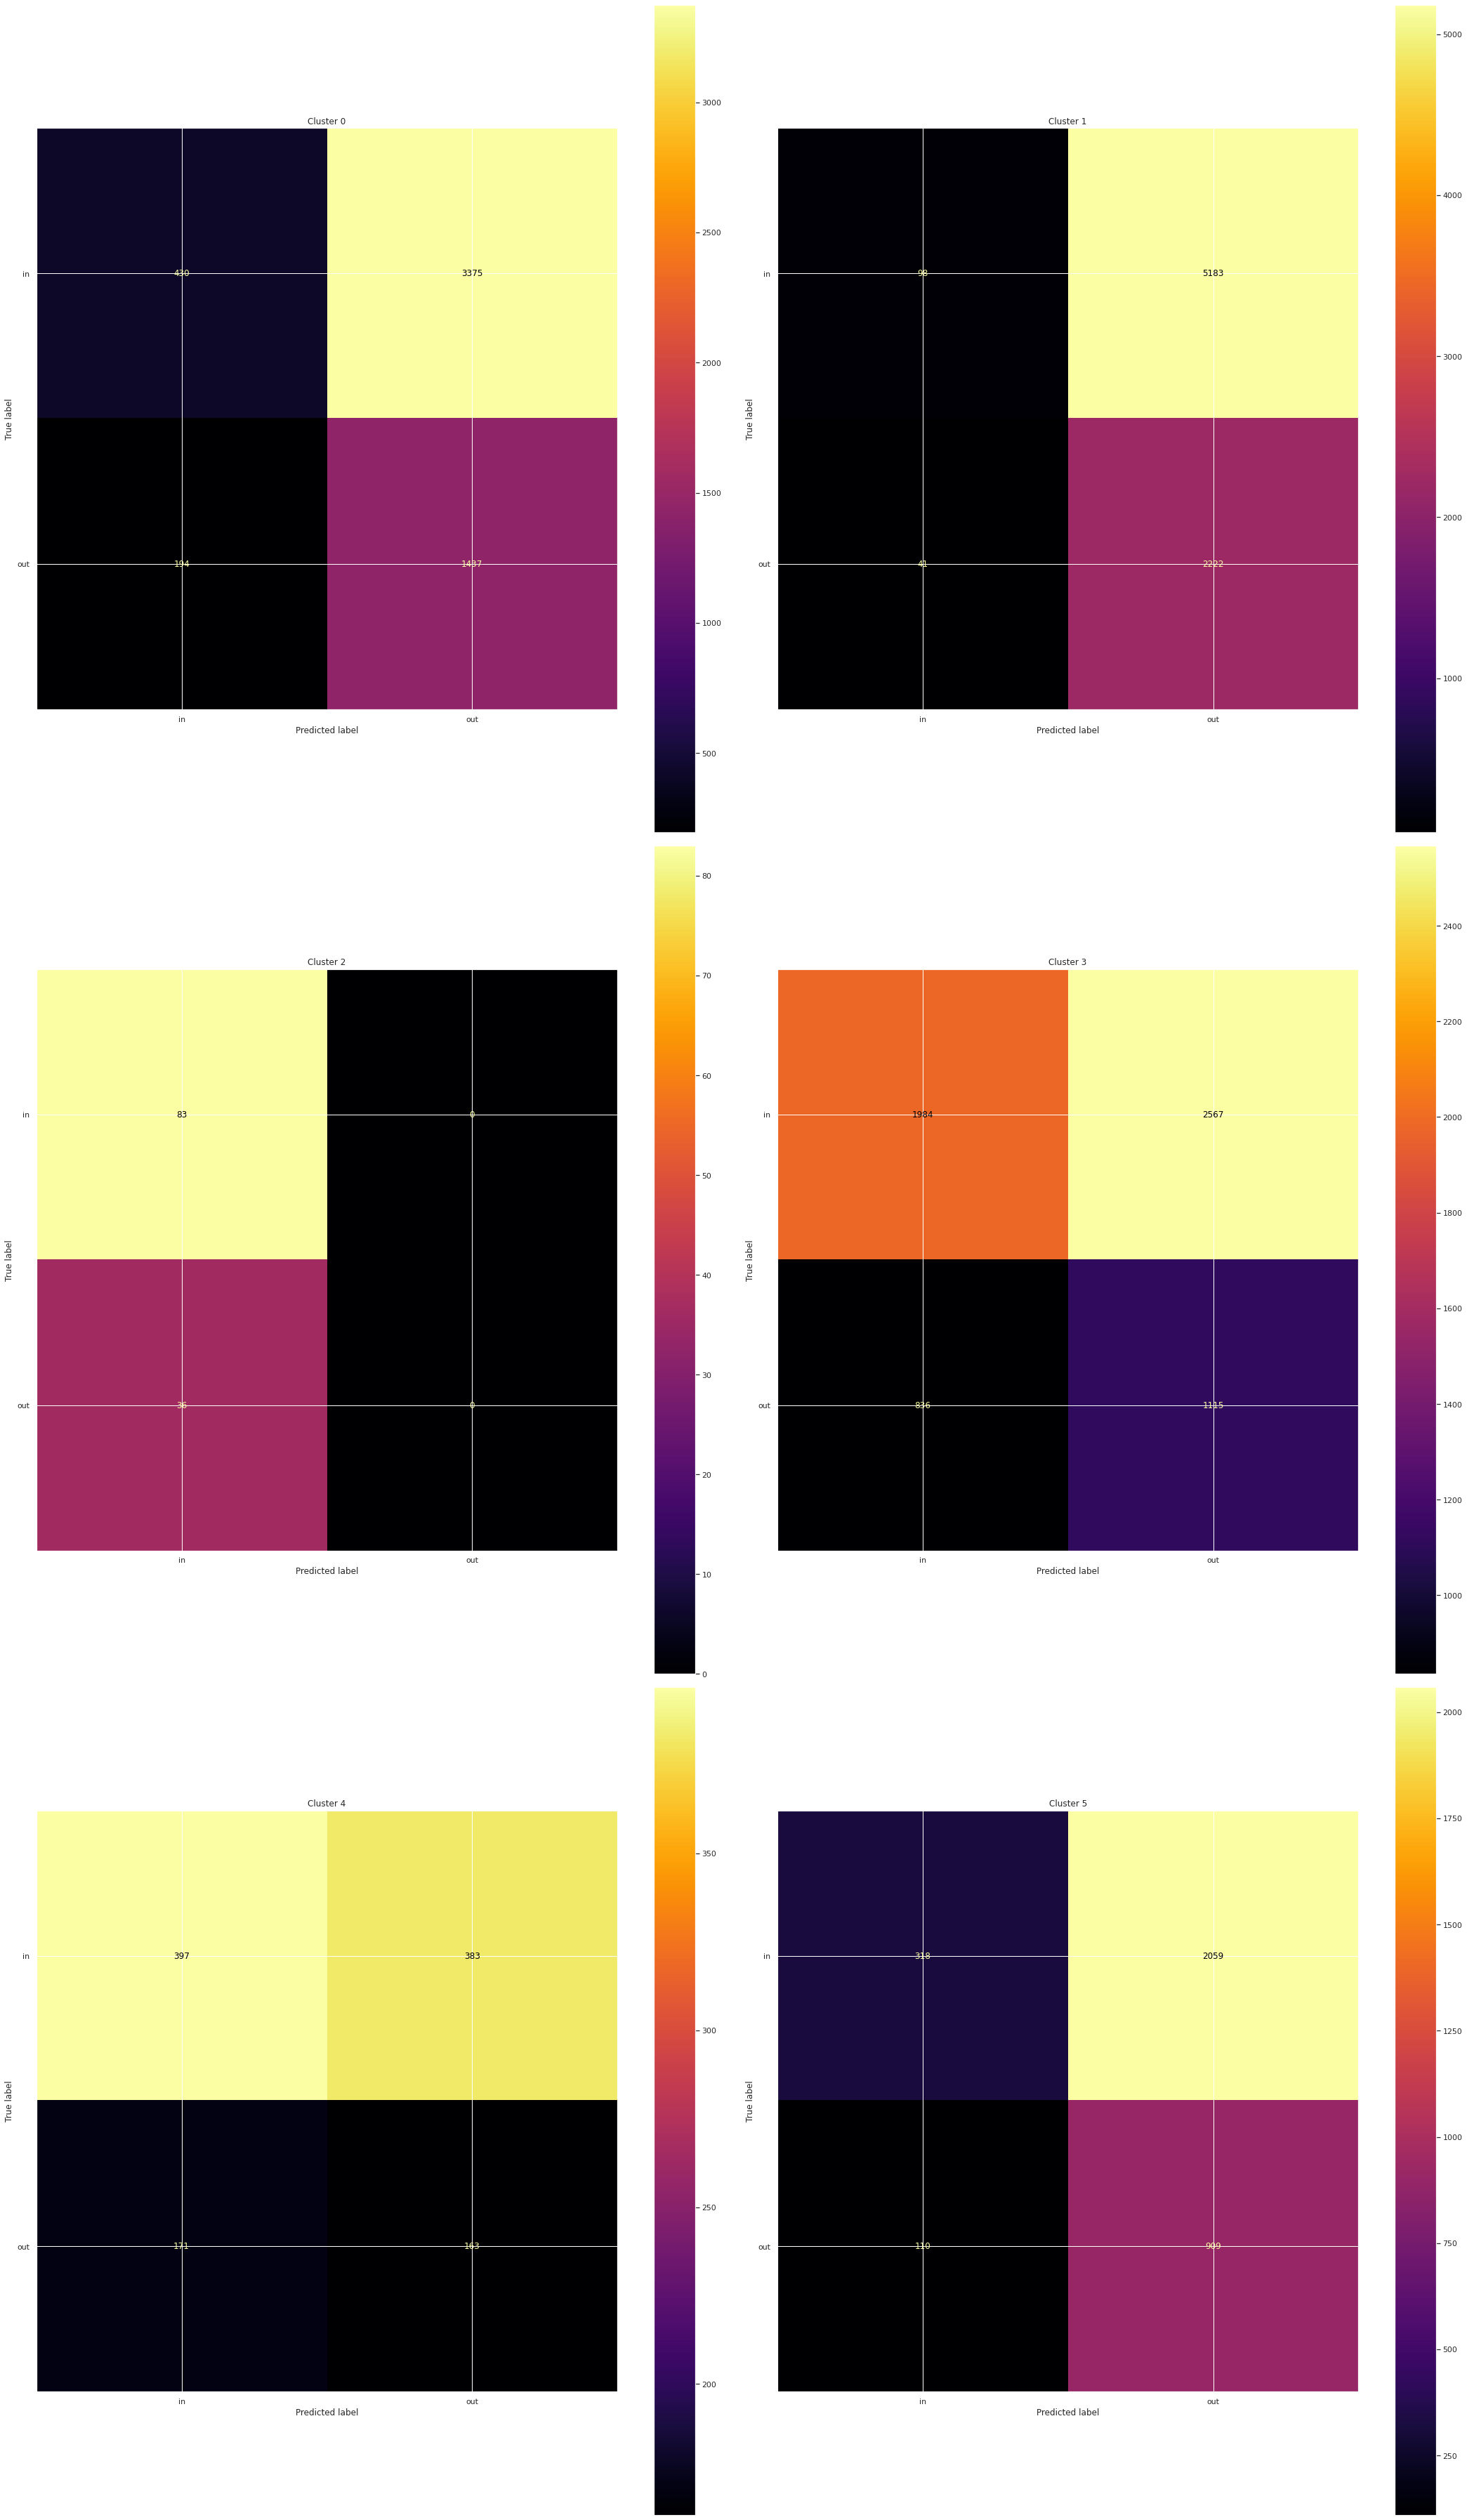

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(30, 50))
axs_list = axs.ravel()
axs_index = 0

for a in adult_test_subset_cluster.groupby(['Cluster']):
    cluster = a[0]
    print(f"{cluster=}")
    # taking all the attack models belonging to that cluster
    elements_belonging_to_cluster = a[1].index.values.tolist()
    atk0, atk1 = [], [] # attack models for label 0 and 1
    for elem in elements_belonging_to_cluster:
        a0, a1 = get_attack_mod(ind)
        atk0.append(a0)
        atk1.append(a1)
    print(f"{len(atk0)=} {len(atk1)=}")
    
    hard_voting_0 = HardVotingClassifier(classifiers=atk0)
    hard_voting_1 = HardVotingClassifier(classifiers=atk1)
    
    
    # elements of the training and test set belonging to the same cluster
    train_subset = get_subset_cluster(adult_train, cluster)
    test_subset = get_subset_cluster(adult_test, cluster)
    
    probs_train = black_box.predict_proba(train_subset[feat_cols].to_numpy())
    probs_test = black_box.predict_proba(test_subset[feat_cols].to_numpy())
    
    ones_train, zeroes_train = split_probs_array(probs_train)
    ones_test, zeroes_test = split_probs_array(probs_test)
    
    # some may be empty
    atk_0_train, atk_1_train, atk_0_test, atk_1_test = [], [], [], []
    
    if len(zeroes_train) > 0:
        atk_0_train = hard_voting_0.predict(zeroes_train)
    else:
        print(f"{zeroes_train=}")

    if len(ones_train) > 0:
        atk_1_train = hard_voting_1.predict(ones_train)
    else:
        print(f"{ones_train=}")
        
    if len(zeroes_test) > 0:
        atk_0_test = hard_voting_0.predict(zeroes_test)
    else:
        print(f"{zeroes_test=}")
        
    if len(ones_test) > 0:
        atk_1_test = hard_voting_1.predict(ones_test)
    else:
        print(f"{ones_test=}")
        
    train_results = np.concatenate((atk_0_train, atk_1_train))
    train_labels  = ["in"] * len(train_results)
    test_results  = np.concatenate((atk_0_test, atk_1_test))
    test_labels   = ["out"] * len(test_results)
    
    full_results  = np.concatenate((train_results, test_results))
    full_labels   = np.concatenate((train_labels, test_labels))
    
    mask = full_results != "even" # exclude from the classification the data with "even"
    print(f"{sum(mask)-len(mask)}/{len(mask)} were even")
    report_full = classification_report(full_labels[mask], full_results[mask])
    
    with open(str(BASE_VOTING_PATH / f"cluster_{cluster}.txt"), "w") as f:
        f.write(report_full)
    
    ConfusionMatrixDisplay.from_predictions(full_labels[mask], full_results[mask], ax=axs_list[axs_index], cmap='inferno')
    axs_list[axs_index].set_title(f"Cluster {cluster}")
    axs_index += 1
plt.tight_layout()